<a href="https://colab.research.google.com/github/geomyll33/Beautez/blob/master/%CE%95%CE%A5%CE%94%CE%91%CE%A0_project_STATS_ARIMA_Profet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **ΒΙΒΛΙΟΘΗΚΕΣ**

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import seaborn as sns # Visualization
import matplotlib.pyplot as plt # Visualization

from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

import warnings # Supress warnings 
warnings.filterwarnings('ignore')
from IPython.display import display, Markdown

In [ ]:
from pandas import Grouper
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA

In [ ]:
from time import time
import matplotlib.ticker as tkr
from scipy import stats

from sklearn import preprocessing
from statsmodels.tsa.stattools import pacf
%matplotlib inline
import datetime as dt
from datetime import datetime, date
import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import EarlyStopping

Τα δεδομένα χρονοσειρών ειναι σε μορφή πίνακα ( αρχεία csv).

Τοποθετήθηκαν όλες οι πληροφορίες ανά χρονική στιγμή 
(μετρητές, δοκιμές, καταμετρήσεις δοκιμασμένων μετρητών, θραύσεις, καταμετρήσεις 10 ετών, αλλαγή στοιχείων παροχής, γεωγραφικός προσδιορισμός παροχών).

Οι κατηγορικές μεταβλητές αφου αξιολογήθηκαν με Heatmap of co-relation μεταβλητών , αυτες που επηρέαζαν  σημαντικά , μετατράπηκαν με την μέθοδο One-hot encoding δημιουργώντας νέες στήλες που υποδεικνύουν την παρουσία (ή απουσία) κάθε πιθανής τιμής στα αρχικά δεδομένα.
Διαμόρφωση όλων των δεδομένων  στον σωστό τύπο , date , int ,float.Τέλος το dataset σχετιζεται  με χρονοσειρές. Στην περιπτωση μας ,ενώ έχουμε τη στήλη Ημερομηνία(timestamp) που προσδιορίζει τον χρόνο ,οι χρονικές σφραγίδες δεν είναι ισοδύναμες  χρονοσειρές γιαυτο και μετατράπηκαν σε ισοδύναμες ανα μήνα με την βοηθεια του resize() , groupby() και ffill()-συμπλήρωση της κενης τιμής απο την προηγούμενη- απο τη βιβλιοθηκη pandas.
Αρχικα θα γινει προσσέγγιγη Univariate μίας παροχής δηλαδή μόνο οι τιμες των  μετρητών ανα παροχή σε σχέση με το χρόνο,όπου θα ελεγθεί στατιστικά , θα δημιουργηθουν κάποιες νεες μεταβλητές  (στατιστικές, χρονικές, εποχικές) όπου θα γίνουν προβλέψεις με ARIMA, naive,  ProPhet,LSTM
Μεταγενεστερα θα ενσωματωθούν όλα τα dataset των μετρητών σε ενα training set, με την βοηθεια της GLUON TS  όπoυ θα δημιουργηθεί ένα global model των μετρητών, για  probabilistic πρόβλεψη άλλων νέων μετρητών.

In [ ]:
df = pd.read_csv('/content/527163_ΟΗ_Μ.csv')

targets = ['indication']
features = [feature for feature in df.columns if feature not in targets]
df.head()

,timestamp,provision_id,meter_id,indication,meter_var_normal,meter_var_stop,provision_var_change,provision_var_normal
0,15-03-01,527163,A86P05630,18406,1,0,0,1
1,15-04-01,527163,A86P05630,18831,1,0,0,1
2,15-05-01,527163,A86P05630,19161,1,0,0,1
3,15-06-01,527163,A86P05630,19541,1,0,0,1
4,15-07-01,527163,A86P05630,19906,1,0,0,1


In [ ]:
df.tail()

,timestamp,provision_id,meter_id,indication,meter_var_normal,meter_var_stop,provision_var_change,provision_var_normal
230,15-05-20,527163,A18P39372,1657,1,0,0,1
231,15-06-20,527163,A18P39372,1836,1,0,0,1
232,15-07-20,527163,A18P39372,2029,1,0,0,1
233,15-08-20,527163,A18P39372,2197,1,0,0,1
234,15-09-20,527163,A18P39372,2354,1,0,0,1


# **Στατιστική Προεπεξεργασία δεδομένων**

Μια χρήσιμη κατάταξη για την επιλογή μεθόδων πρόβλεψης είναι η διάσπαση μιας χρονοσειράς σε συστηματικά και μη συστηματικά στοιχεία.
*   Συστηματικό: Συστατικά των χρονοσειρών που έχουν σταθερή επανάληψη ή μεταβαλλόμενη  και 
μπορούν να περιγραφούν και να μοντελοποιηθούν.
*   Μη συστηματικό: Στοιχεία των χρονοσειρών που δεν μπορούν να μοντελοποιηθούν άμεσα.


Μια δεδομένη χρονική σειρά θεωρείται ότι αποτελείται από τρία συστηματικά στοιχεία, όπως 
   

*   επίπεδο,
*   τάση,
*  εποχικότητα

και ένα μη συστηματικό στοιχείο που ονομάζεται 
*   θόρυβος.

Αυτά τα στοιχεία ορίζονται ως εξής:

Επίπεδο: Η μέση τιμή της σειράς.

Τάση: Η αυξανόμενη ή φθίνουσα τιμή της σειράς.

Εποχικότητα: Ο επαναλαμβανόμενος βραχυπρόθεσμος κύκλος της σειράς.

Θόρυβος: Η τυχαία παραλλαγή της σειράς.

Το σύνολο δεδομένων χρονοσειρών μας μπορεί να περιέχει μια τάση. Μια τάση είναι μια συνεχής αύξηση ή μείωση της σειράς με την πάροδο του χρόνου. Μπορεί να υπάρξει όφελος στον εντοπισμό, τη μοντελοποίηση και ακόμη και την κατάργηση πληροφοριών τάσεων από το σύνολο δεδομένων χρονοσειρών σας.

Τα σύνολα δεδομένων χρονοσειρών μπορούν να περιέχουν ένα εποχιακό στοιχείο. 

Αυτός είναι ένας κύκλος που επαναλαμβάνεται με την πάροδο του χρόνου, όπως μηνιαίος ή ετήσιος. Αυτός ο επαναλαμβανόμενος κύκλος μπορεί να αποκρύψει το σήμα που θέλουμε να μοντελοποιήσουμε κατά την πρόβλεψη και με τη σειρά του μπορεί να παρέχει ένα ισχυρό σήμα στα προγνωστικά μοντέλα μας.

Υπάρχουν πολλοί τύποι εποχικότητας: ώρα της ημέρας, καθημερινά, εβδομαδιαία, μηνιαία, ετήσια κ.λπ. Ο εντοπισμός του εάν υπάρχει ένα στοιχείο εποχικότητας στο πρόβλημα των χρονολογικών σειρών μας είναι υποκειμενικό. 

Η απλούστερη προσέγγιση για να προσδιοριστεί εάν υπάρχει μια πτυχή της εποχικότητας είναι ο σχεδιασμός και έλεγχος των δεδομένων,  σε διαφορετικές κλίμακες και με την προσθήκη γραμμών τάσης.

Μια χρονική σειρά όπου το εποχιακό στοιχείο έχει αφαιρεθεί ονομάζεται εποχιακή στάσιμη.

Εάν ένα σύνολο δεδομένων που δεν έχει τάση ή καταργούμε με επιτυχία την τάση, το σύνολο δεδομένων λέγεται ότι έχει σταθερή τάση.



Έλεγχος χαρακτηριστικών του **dataset**

In [ ]:
def report(df):
    display(Markdown('<b>head():</b>'))
    display(df.head())
    display(Markdown('<b>describe():</b>'))
    display(df.describe())
    display(Markdown('<b>info():</b>'))
    display(df.info(verbose=True))
    display(Markdown('<b>infer_dtype():</b>'))
    display(df.apply(lambda x: pd.api.types.infer_dtype(x.values)))
report(df)

<b>head():</b>

,timestamp,provision_id,meter_id,indication,meter_var_normal,meter_var_stop,provision_var_change,provision_var_normal
0,15-03-01,527163,A86P05630,18406,1,0,0,1
1,15-04-01,527163,A86P05630,18831,1,0,0,1
2,15-05-01,527163,A86P05630,19161,1,0,0,1
3,15-06-01,527163,A86P05630,19541,1,0,0,1
4,15-07-01,527163,A86P05630,19906,1,0,0,1


<b>describe():</b>

,provision_id,indication,meter_var_normal,meter_var_stop,provision_var_change,provision_var_normal
count,235.0,235.000000,235.000000,235.000000,235.000000,235.000000
mean,527163.0,55906.953191,0.970213,0.029787,0.021277,0.974468
std,0.0,27052.856868,0.170363,0.170363,0.144613,0.158071
min,527163.0,1.000000,0.000000,0.000000,0.000000,0.000000
25%,527163.0,34508.500000,1.000000,0.000000,0.000000,1.000000
50%,527163.0,56477.000000,1.000000,0.000000,0.000000,1.000000
75%,527163.0,79240.000000,1.000000,0.000000,0.000000,1.000000
max,527163.0,99849.000000,1.000000,1.000000,1.000000,1.000000


<b>info():</b>

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235 entries, 0 to 234
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   timestamp             235 non-null    object
 1   provision_id          235 non-null    int64 
 2   meter_id              235 non-null    object
 3   indication            235 non-null    int64 
 4   meter_var_normal      235 non-null    int64 
 5   meter_var_stop        235 non-null    int64 
 6   provision_var_change  235 non-null    int64 
 7   provision_var_normal  235 non-null    int64 
dtypes: int64(6), object(2)
memory usage: 14.8+ KB


None

<b>infer_dtype():</b>

timestamp                string
provision_id            integer
meter_id                 string
indication              integer
meter_var_normal        integer
meter_var_stop          integer
provision_var_change    integer
provision_var_normal    integer
dtype: object


Χαρακτηριστικά:

provision_id   είναι ο αριθμός παροχής του κτηρίου

meter_id  είναι ο αριθμός μετρητή του κτηρίου

meter_var_normal είναι η ένδειξη οτι ο μετρητη λειτουργει κανονικά 

meter_var_stop είναι η ένδειξη ότι ο μετρητής έχει γίνει διακοπή

provision_var_change είναι η ένδειξη οτι στην παροχή έχει γίνει κάποια μεταβολή

provision_var_normal είναι η ένδειξη ότι η παροχή λειτουργεί κανονικά


Στόχος:

indication είναι η ένδειξη των  μετρητων της παροχής που δείχνει τη κατανάλωση νερού σε κμ3

Αφαιρούμε όλα κατηγορικά δεδομένα , αρχικα θα γίνει προσέγγιση Univariate.
Για να διευκολύνουμε τη σχεδίαση γραφημάτων, ορίζουμε το ευρετήριο του πλαισίου δεδομένων pandas στο timestamp. Κατά τη δημιουργία γραφημάτων, το ευρετήριο θα ενεργήσει από προεπιλογή ως άξονας x και αφού έχει μόνο μία ακόμη στήλη, που θα ληφθεί αυτόματα ως άξονας y

In [ ]:
df1 = df.drop(['provision_id','meter_id','meter_var_normal','meter_var_stop','provision_var_change','provision_var_normal'], axis=1)


In [ ]:
#column 'timestamp' is provided in string format. Convert it to the datetime64[ns] data type.
from datetime import datetime, date 

df1['timestamp'] = pd.to_datetime(df1['timestamp'],infer_datetime_format=True)
df1=df1.set_index(['timestamp'])
df1.head()

,indication
timestamp,
2001-03-15,18406
2001-04-15,18831
2001-05-15,19161
2001-06-15,19541
2001-07-15,19906


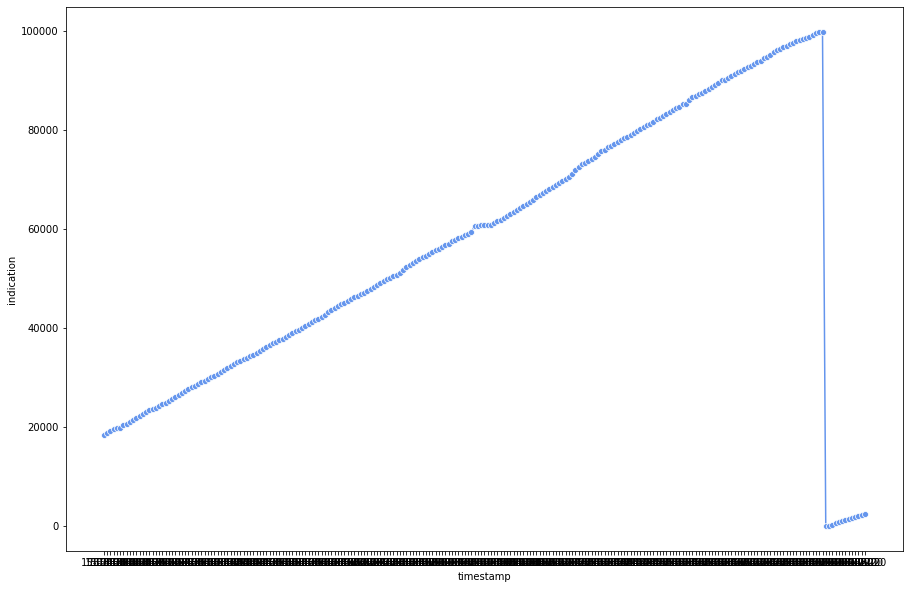

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 10))

sns.lineplot(x=df.timestamp, y=df.indication, ax=ax, color='cornflowerblue', marker='o')

plt.show()

In [ ]:
#Προσδιορισμός κυλιόμενων στατιστικών στις αρχικές τιμές μετρήσεων
rolmean = df1.rolling(window=12).mean() #το μέγεθος παραθύρου 12 δηλώνει 12 μήνες, δίνοντας κυλιόμενο μέσο σε ετήσιο επίπεδο
rolstd = df1.rolling(window=12).std()
print(rolmean,rolstd)


              indication
timestamp               
2001-03-15           NaN
2001-04-15           NaN
2001-05-15           NaN
2001-06-15           NaN
2001-07-15           NaN
...                  ...
2020-05-15  25526.250000
2020-06-15  17382.166667
2020-07-15   9230.500000
2020-08-15   1092.833333
2020-09-15   1288.916667

[235 rows x 1 columns]               indication
timestamp               
2001-03-15           NaN
2001-04-15           NaN
2001-05-15           NaN
2001-06-15           NaN
2001-07-15           NaN
...                  ...
2020-05-15  44764.293754
2020-06-15  38524.891920
2020-07-15  28545.633904
2020-08-15    767.730994
2020-09-15    763.995295

[235 rows x 1 columns]


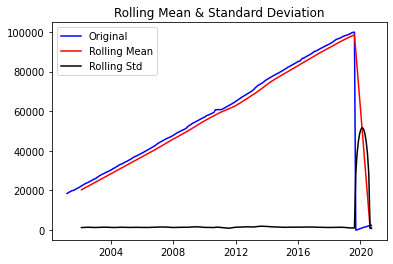

In [ ]:
#Plot rolling statistics
orig = plt.plot(df1, color='blue', label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

Από το παραπάνω γράφημα, βλέπουμε ότι ο ίδιος ο κυλιόμενος μέσος έχει ένα στοιχείο τάσης παρόλο που η τυπική απόκλιση κύλισης είναι αρκετά σταθερή με το χρόνο. Προκειμένου οι χρονοσειρές μας να είναι σταθερές, πρέπει να διασφαλίσουμε ότι τόσο τα κυλιόμενα στατιστικά στοιχεία, δηλαδή: μέση & std. dev παραμείνει αμετάβλητη του χρόνου ή σταθερή με το χρόνο. Έτσι, οι καμπύλες και για τους δύο πρέπει να είναι παράλληλες με τον άξονα Χ, ο οποίος στην περίπτωση μας το mean dev δεν είναι έτσι.

Για να αυξήσουμε περαιτέρω την υπόθεσή μας ότι οι χρονοσειρές δεν είναι σταθερές, ας πραγματοποιήσουμε τη δοκιμή ADCF.

In [ ]:
#Perform Augmented Dickey–Fuller test:
print('Results of Dickey Fuller Test:')
dftest = adfuller(df1['indication'], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print(dfoutput)

Results of Dickey Fuller Test:
Test Statistic                  -1.592498
p-value                          0.487361
#Lags Used                       0.000000
Number of Observations Used    234.000000
Critical Value (1%)             -3.458608
Critical Value (5%)             -2.873972
Critical Value (10%)            -2.573396
dtype: float64


Για να είναι στατική μια σειρά, η δοκιμή ADCF πρέπει να έχει:

η τιμή p να είναι χαμηλή (σύμφωνα με την μηδενική υπόθεση)
Οι κρίσιμες τιμές στα διαστήματα εμπιστοσύνης 1%, 5%, 10% πρέπει να είναι όσο το δυνατόν πιο κοντά στα στατιστικά στοιχεία δοκιμής
Από το παραπάνω αποτέλεσμα της δοκιμής ADCF, βλέπουμε ότι η τιμή p (στο μέγιστο μπορεί να είναι 0,5) είναι στο όριο. Επίσης, οι κρίσιμες τιμές δεν απέχουν και πολύ απ'ο τις Στατιστικές δοκιμών. Ως εκ τούτου, μπορούμε να πούμε με ασφάλεια ότι η σειρά Χρόνου μας αυτή τη στιγμή δεν είναι σταθερή

# **Μετασχηματισμός δεδομένων για επίτευξη σταθερότητας**

Υπάρχουν μερικοί τρόποι για να επιτευχθεί η στασιμότητα μέσω του μετασχηματισμού δεδομένων όπως η λήψη log10, loge, τετραγωνικής, τετραγωνικής ρίζας, κύβου, ρίζας κύβου, εκθετικής αποσύνθεσης, μετατόπισης χρόνου και ούτω καθεξής.

Στη  μελέτη μας, θα ξεκινήσουμε με μετασχηματισμούς καταγραφής. Στόχος μας είναι να αφαιρέσουμε το στοιχείο της τάσης. Ως εκ τούτου, θα ελενξουμε μετά τη λήψη log λειτούργησε θετικά ο μετασχηματισμός δεδομένων μας δημιουργώντας  πιο επίπεδες καμπύλες (δηλαδή: παράλληλος σε άξονα x) για χρονοσειρές και κυλιόμενο μέσο .

**Log Scale Transformation**

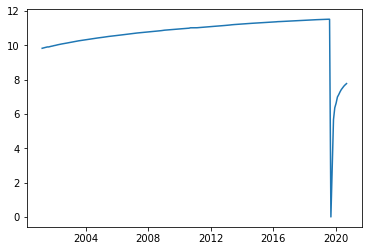

In [ ]:
#Εκτίμηση τάσης
df1_logScale = np.log(df1)
plt.plot(df1_logScale)

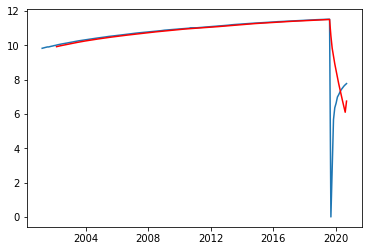

In [ ]:
#Ο παρακάτω κυλιόμενος μετασχηματισμός απαιτείται για να κάνει τη σειρά στάσιμη
movingAverage = df1_logScale.rolling(window=12).mean()
movingSTD = df1_logScale.rolling(window=12).std()
plt.plot(df1_logScale)
plt.plot(movingAverage, color='red')

Από το παραπάνω γράφημα, βλέπουμε ότι παρόλο που ο κυλιόμενος μέσος όρος δεν είναι στατικός, είναι ακόμα καλύτερος από την προηγούμενη περίπτωση, όπου δεν εφαρμόστηκε μετατροπη στη σειρά. Έτσι μπορούμε τουλάχιστον να πούμε ότι βαδίζουμε προς τη σωστή κατεύθυνση.Παρακάτω ο έλεγχος στασιμότητας

In [ ]:
def test_stationarity(timeseries):
    
    #Determine rolling statistics
    movingAverage = timeseries.rolling(window=12).mean()
    movingSTD = timeseries.rolling(window=12).std()
    
    #Plot rolling statistics
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    std = plt.plot(movingSTD, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey–Fuller test:
    print('Results of Dickey Fuller Test:')
    dftest = adfuller(timeseries['indication'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

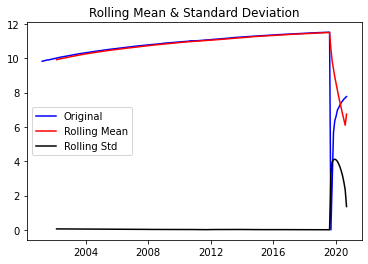

Results of Dickey Fuller Test:
Test Statistic                  -3.332895
p-value                          0.013471
#Lags Used                       2.000000
Number of Observations Used    232.000000
Critical Value (1%)             -3.458855
Critical Value (5%)             -2.874080
Critical Value (10%)            -2.573453
dtype: float64


In [ ]:
test_stationarity(df1_logScale)

Η τιμή p έχει μειωθεί από 0.487361 σε 0.013471. Οι κρίσιμες τιμές σε διαστήματα εμπιστοσύνης 1%, 5%, 10% είναι πολύ κοντά στο Test Statistic. Έτσι, από τα παραπάνω 2 σημεία, μπορούμε να πούμε ότι η δεδομένη σειρά μας είναι στάσιμη με  μεγαλύτερη ακρίβεια.



Γνωρίζουμε από το παραπάνω γράφημα ότι τόσο η χρονολογική σειρά με λογαριθμική κλίμακα  όσο και ο κινούμενος μέσος όρος της έχουν συνιστώσα τάσης. Έτσι μπορούμε να εφαρμόσουμε ακομη μια τεχνοτροπία:
αφαίρεση το ένα από το προηγούμενο θα πρέπει να αφαιρέσει το στοιχείο τάσης και των δύο. 
Αναλυτικά:

logscaleL = stationarypart (L1) + τάση (LT)

movingavgoflogscaleA = stationarypart (A1) + τάση (AT)

Αποτελέσματα R = L − A = (L1 + LT) - (A1 + AT) = (L1 − A1) + (LT − AT)

Δεδομένου ότι τα L & A είναι σειρές και κινείται κατά μέσο όρο, η τάση τους θα είναι λίγο πολύ ίδια, ως εκ τούτου

Το LT-AT ισούται σχεδόν με 0

Έτσι, το στοιχείο της τάσης θα αφαιρεθεί σχεδόν. Και έχουμε,

R = L1 − A1, η τελική καμπύλη χωρίς τάσεις

In [ ]:
df1LogScaleMinusMovingAverage = df1_logScale - movingAverage
df1LogScaleMinusMovingAverage.head(12)

#Remove NAN values
df1LogScaleMinusMovingAverage.dropna(inplace=True)
df1LogScaleMinusMovingAverage.head(10)

,indication
timestamp,
2002-02-15,0.093707
2002-03-15,0.092049
2002-04-15,0.092319
2002-05-15,0.094659
2002-06-15,0.089743
2002-07-15,0.086376
2002-08-15,0.084861
2002-09-15,0.084021
2002-10-15,0.080233


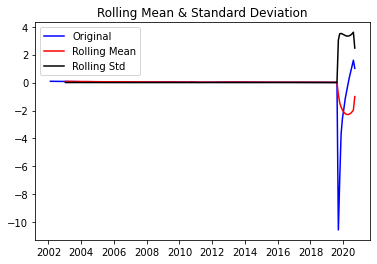

Results of Dickey Fuller Test:
Test Statistic                -6.990144e+00
p-value                        7.782932e-10
#Lags Used                     0.000000e+00
Number of Observations Used    2.230000e+02
Critical Value (1%)           -3.460019e+00
Critical Value (5%)           -2.874590e+00
Critical Value (10%)          -2.573725e+00
dtype: float64


In [ ]:
test_stationarity(df1LogScaleMinusMovingAverage)

Από το παραπάνω γράφημα, παρατηρούμε ότι η διαίσθησή μας ότι «αφαιρώντας δύο σχετικές σειρές που έχουν παρόμοια στοιχεία τάσης θα κάνει το αποτέλεσμα σταθερό» είναι αλήθεια. Βρίσκουμε ότι:

Η τιμή p έχει μειωθεί από 0.487361 σε 7.782932e-10.
Οι κρίσιμες τιμές σε διαστήματα εμπιστοσύνης 1%, 5%, 10% απομακρύνονται σε σχέση με την ποηγούμενη προσσέγγιση στο Test Statistic. Έτσι, από τα παραπάνω 2 σημεία, μπορούμε να πούμε ότι η δεδομένη σειρά μας είναι στάσιμη επίσης.
Όμως, στο πνεύμα της μεγαλύτερης ακρίβειας, ας εξερευνήσουμε και προσπαθούμε να βρούμε μια καλύτερη κλίμακα από την τρέχουσα καταγραφή μας.

Στο επομενο στάδιο θα δοκιμαστεί η εκθετική αποσύνθεση.

A. Μια ποσότητα υπόκειται σε εκθετική διάσπαση εάν μειώνεται με ρυθμό ανάλογο με την τρέχουσα τιμή του. Συμβολικά, αυτή η διαδικασία μπορεί να εκφραστεί με την ακόλουθη διαφορική εξίσωση, όπου Ν είναι η ποσότητα και λ (λάμδα) είναι ένας θετικός ρυθμός που ονομάζεται σταθερή εκθετικής αποσύνθεσης:

dN / dt = −λN
Η λύση σε αυτήν την εξίσωση (βλ. Παράγωγο παρακάτω) είναι:
N (t) = N0 ∗ e − λt
όπου N (t) είναι η ποσότητα στο χρόνο t και N0 = N (0) είναι η αρχική ποσότητα, δηλαδή η ποσότητα στο χρόνο t = 0.

Η μισή διάρκεια είναι ο χρόνος που απαιτείται για τη μείωση της ποσότητας που φθάνει στο μισό της αρχικής της τιμής.
 Συμβολίζεται με t1 / 2. Ο χρόνος μισής διάρκειας μπορεί να γραφτεί με όρους της σταθεράς αποσύνθεσης ως:

t1 / 2 = ln (2) / λ 

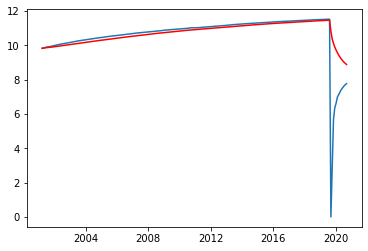

In [ ]:
exponentialDecayWeightedAverage = df1_logScale.ewm(halflife=12, min_periods=0, adjust=True).mean()
plt.plot(df1_logScale)
plt.plot(exponentialDecayWeightedAverage, color='red')

Από το παραπάνω γράφημα, φαίνεται ότι η εκθετική αποσύνθεση δεν έχει κανένα πλεονέκτημα έναντι της λογαριθμικής μετατροπής  καθώς και οι δύο αντίστοιχες καμπύλες είναι σχεδόν παρόμοιες καθως οι καμπύλεσ είναι λίγο καλύτερες μετά το 2019. Εκτελούμε ξανά το τεστ ADCF στην παρακάτω σειρά αποσύνθεσης

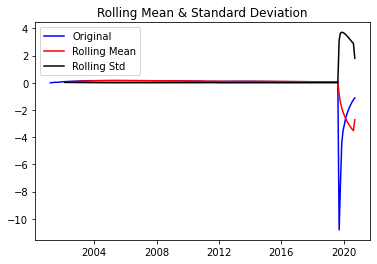

Results of Dickey Fuller Test:
Test Statistic                -6.220040e+00
p-value                        5.250436e-08
#Lags Used                     0.000000e+00
Number of Observations Used    2.340000e+02
Critical Value (1%)           -3.458608e+00
Critical Value (5%)           -2.873972e+00
Critical Value (10%)          -2.573396e+00
dtype: float64


In [ ]:
df1LogScaleMinusExponentialMovingAverage = df1_logScale - exponentialDecayWeightedAverage
test_stationarity(df1LogScaleMinusExponentialMovingAverage)


Παρατηρούμε ότι η χρονοσειρά είναι στάσιμη και επίσης η σειρά για κίνηση avg & std. dev είναι  παράλληλες με τον άξονα Χ, έτσι δεν έχουν επίσης τάση.
Επίσης,

Η τιμή p έχει μειωθεί από 0.487361 σε 5.250436e-08.
Η τιμή Test Statistic είναι το ίδιο  κοντά στις κρίσιμες τιμές.
Και τα δύο σημεία λένε ότι ο τρέχων μετασχηματισμός μας είναι ίδιος από τον προηγούμενο μετασχηματισμό. Παρόλο που δεν μπορούσαμε να παρατηρήσουμε διαφορές κοιτάζοντας οπτικά τα γραφήματα, οι δοκιμές επιβεβαίωσαν ότι η είναι περιπου ιδιες.
Αλλά ας δοκιμάσουμε μια ακόμη φορά και να βρούμε αν υπάρχει ακόμη καλύτερη λύση. Θα δοκιμάσουμε την απλή τεχνική χρονικής μετατόπισης, η οποία είναι απλώς:

Δεδομένου ενός συνόλου παρατήρησης σχετικά με τις χρονοσειρές:

x0, x1, x2, x3, .... xn
Οι μετατοπισμένες τιμές θα είναι:

null, x0, x1, x2, .... xn <---- βασικά όλα τα xi μετατοπίστηκαν κατά 1 θέση προς τα δεξιά

Έτσι, οι χρονοσειρές με τις μετατοπισμένες τιμές είναι:

null, (x1 − x0), (x2 − x1), (x3 − x2), (x4 − x3), .... (xn − xn − 1) 

# **Χρονική μετατόπιση -time shift Transformation**

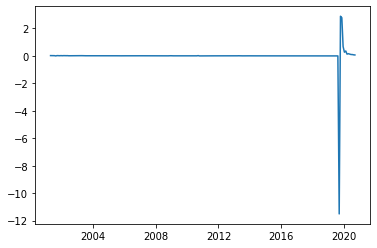

In [ ]:
df1LogDiffShifting = df1_logScale - df1_logScale.shift()
plt.plot(df1LogDiffShifting)

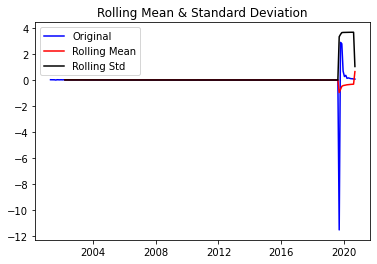

Results of Dickey Fuller Test:
Test Statistic                -1.170427e+01
p-value                        1.542290e-21
#Lags Used                     2.000000e+00
Number of Observations Used    2.310000e+02
Critical Value (1%)           -3.458980e+00
Critical Value (5%)           -2.874135e+00
Critical Value (10%)          -2.573482e+00
dtype: float64


In [ ]:
df1LogDiffShifting.dropna(inplace=True)
test_stationarity(df1LogDiffShifting)

Από τα παραπάνω 2 γραφήματα, μπορούμε να δούμε ότι, οπτικά, αυτό είναι το καλύτερο αποτέλεσμα καθώς η σειρά μας μαζί με τις μετατοπισμένες  στατιστικές τιμές του κινούμενου μέσου και του κινούμενου std. dev είναι πολύ επίπεδη και σταθερή. Όμως, η δοκιμή ADCF μάς δείχνει ότι:

Η τιμή p του 1.542290e-21  είναι πολύ μικρή όπως τους προηγούμενους μετασχηματισμούς.
Η τιμή test-statistics σε σχέση με τις  κρίσιμες τιμές είναι όσο απο του rolling mean και st. dev.μετασχηματισμο , όχι η καλύτερη.


Δοκιμάσαμε λοιπόν 3 διαφορετικούς μετασχηματισμούς: log, exp decay & time shift. 
Για απλότητα, θα ακολουθήσουμε την λογαριθμική μετατροπή . Ο λόγος για αυτό είναι ότι μπορούμε να επανέλθουμε στην αρχική κλίμακα κατά τη διάρκεια των προβλέψεων.

Ας αναλύσουμε τώρα τα 3 στοιχεία της σειράς λογαριθμικής μετατροπής  χρησιμοποιώντας την  συνάρτηση decompose(). Μόλις διαχωρίσουμε τα στοιχεία μας, μπορούμε απλά να αγνοήσουμε την τάση και την εποχικότητα και να ελέγξουμε τη φύση του υπόλειπου μέρους.

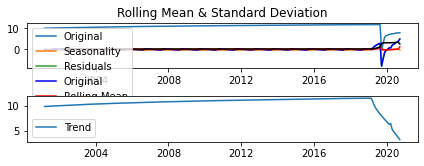

Results of Dickey Fuller Test:
Test Statistic                -5.690134e+00
p-value                        8.106926e-07
#Lags Used                     1.200000e+01
Number of Observations Used    2.220000e+02
Critical Value (1%)           -3.460154e+00
Critical Value (5%)           -2.874649e+00
Critical Value (10%)          -2.573757e+00
dtype: float64


In [ ]:
decomposition = seasonal_decompose(df1_logScale, freq=12, model='additive', extrapolate_trend='freq')

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(df1_logScale, label='Original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')

plt.subplot(411)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')

plt.subplot(411)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')

plt.tight_layout()

decomposedLogData = residual
decomposedLogData.dropna(inplace=True)
test_stationarity(decomposedLogData)

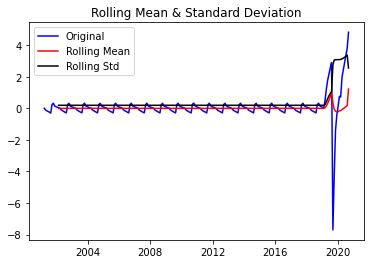

Results of Dickey Fuller Test:
Test Statistic                -5.690134e+00
p-value                        8.106926e-07
#Lags Used                     1.200000e+01
Number of Observations Used    2.220000e+02
Critical Value (1%)           -3.460154e+00
Critical Value (5%)           -2.874649e+00
Critical Value (10%)          -2.573757e+00
dtype: float64


In [ ]:
# μπορεί να υπάρχουν περιπτώσεις όπου μια παρατήρηση αποτελείται απλώς από τάση και εποχικότητα. Σε αυτήν την περίπτωση, δεν θα υπάρξει
# οποιοδήποτε υπολειπόμενο συστατικό και αυτό θα είναι μηδενικό ή NaN. Ως εκ τούτου, καταργούμε επίσης τέτοιες περιπτώσεις
decomposedLogData = residual
decomposedLogData.dropna(inplace=True)
test_stationarity(decomposedLogData)

# **Autocorellation-ACF&PACF**

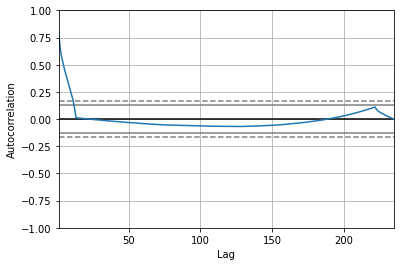

In [ ]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df1_logScale)
plt.show()

**Plotting ACF & PACF**

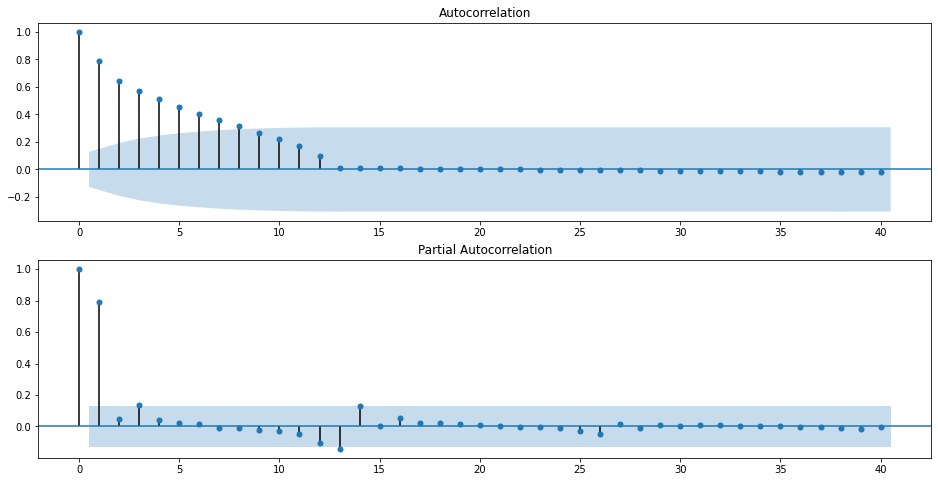

In [ ]:
#ACF & PACF plots


f, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 8))

plot_acf(df1_logScale,lags=40, ax=ax[0])
plot_pacf(df1_logScale,lags=40, ax=ax[1])
plt.show()
    

Από το γράφημα ACF, βλέπουμε ότι η καμπύλη αγγίζει τη γραμμή y = 0,0 στο x = 2. Έτσι, από θεωρία, Q = 2 Από το γράφημα PACF, βλέπουμε ότι η καμπύλη αγγίζει τη γραμμή y = 0,0 στο x = 1. Έτσι, από τη θεωρία, P = 1

Το ARIMA είναι AR + I + MA. Πριν εξετάσουμε ένα μοντέλο ARIMA, ας ελέγξουμε τα αποτελέσματα του μεμονωμένου μοντέλου AR & MA. 
Αυτά τα μοντέλα θα δώσουν μια τιμή RSS. Οι χαμηλότερες τιμές RSS υποδεικνύουν ένα καλύτερο μοντέλο.

# **Building Models**

## **ARIMA**

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Plotting AR model


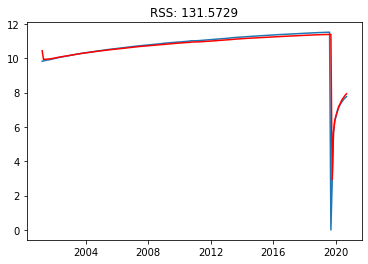

In [ ]:
#AR Model
#making order=(2,1,0) gives RSS=1.5023
model = ARIMA(df1_logScale, order=(2,0,2))
results_AR = model.fit(disp=-1)
plt.plot(df1_logScale)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_AR.fittedvalues - df1_logScale['indication'])**2))
print('Plotting AR model')

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Plotting MA model


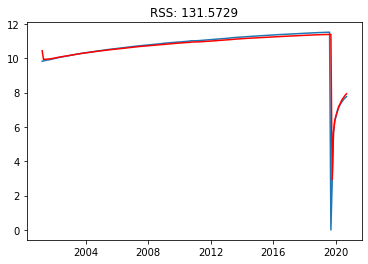

In [ ]:
#MA Model
model = ARIMA(df1_logScale, order=(2,0,2))
results_MA = model.fit(disp=-1)
plt.plot(df1_logScale)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_MA.fittedvalues - df1_logScale['indication'])**2))
print('Plotting MA model')

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Plotting ARIMA model


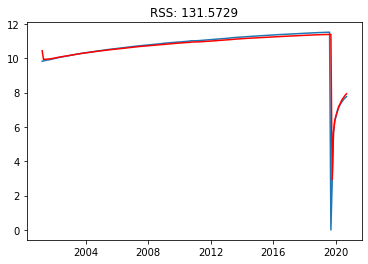

In [ ]:
# AR+I+MA = ARIMA model
model = ARIMA(df1_logScale, order=(2,0,2))
results_ARIMA = model.fit(disp=-1)
plt.plot(df1_logScale)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_ARIMA.fittedvalues - df1_logScale['indication'])**2))
print('Plotting ARIMA model')

In [ ]:
print(results_ARIMA.summary())

                              ARMA Model Results                              
Dep. Variable:             indication   No. Observations:                  235
Model:                     ARMA(2, 2)   Log Likelihood                -265.689
Method:                       css-mle   S.D. of innovations              0.748
Date:                Sat, 13 Mar 2021   AIC                            543.379
Time:                        23:38:32   BIC                            564.136
Sample:                             0   HQIC                           551.747
                                                                              
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               10.4354      0.427     24.466      0.000       9.599      11.271
ar.L1.indication     1.1056      0.342      3.231      0.001       0.435       1.776
ar.L2.indication    -0.1581 

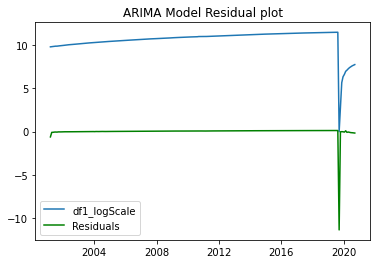

In [ ]:
plt.plot(df1_logScale, label = 'df1_logScale')
plt.plot(results_ARIMA.resid, color ='green',label= 'Residuals')
plt.title('ARIMA Model Residual plot')
plt.legend(loc = 'best')

count    235.000000
mean       0.005055
std        0.749834
min      -11.387479
25%        0.018589
50%        0.067534
75%        0.103059
max        0.126960
dtype: float64


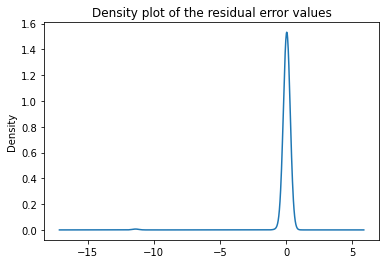

In [ ]:
results_ARIMA.resid.plot(kind='kde')
plt.title('Density plot of the residual error values')
print(results_ARIMA.resid.describe())

##**Προβλεψη και αντιστροφή των μετασχηματισμών**

In [ ]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff.tail())

timestamp
2020-05-15    7.500307
2020-06-15    7.633227
2020-07-15    7.743207
2020-08-15    7.846340
2020-09-15    7.928897
dtype: float64


In [ ]:
#Convert to cumulative sum
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print(predictions_ARIMA_diff_cumsum)

timestamp
2001-03-15      10.435428
2001-04-15      20.366046
2001-05-15      30.306500
2001-06-15      40.242401
2001-07-15      50.188184
                 ...     
2020-05-15    2465.754472
2020-06-15    2473.387699
2020-07-15    2481.130905
2020-08-15    2488.977245
2020-09-15    2496.906142
Length: 235, dtype: float64


In [ ]:
predictions_ARIMA_log = pd.Series(df1_logScale['indication'].iloc[0], index=df1_logScale.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA_log.head()

timestamp
2001-03-15    20.255860
2001-04-15    30.186478
2001-05-15    40.126932
2001-06-15    50.062833
2001-07-15    60.008616
dtype: float64

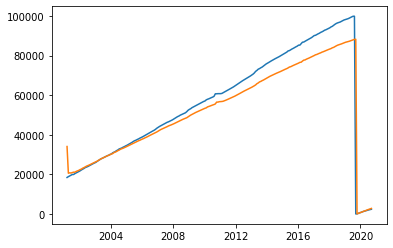

In [ ]:
# Inverse of log is exp.
predictions_ARIMA = np.exp(predictions_ARIMA_diff)
plt.plot(df1)
plt.plot(predictions_ARIMA)


In [ ]:
predictions_ARIMA

timestamp
2001-03-15    34044.660729
2001-04-15    20550.022496
2001-05-15    20753.161988
2001-06-15    20658.903310
2001-07-15    20864.045092
                  ...     
2020-05-15     1808.598301
2020-06-15     2065.705035
2020-07-15     2305.854340
2020-08-15     2556.359900
2020-09-15     2776.362473
Length: 235, dtype: float64

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


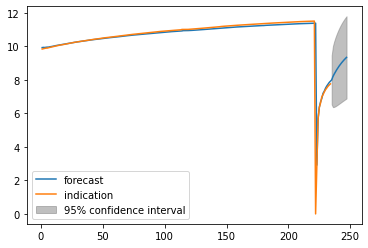

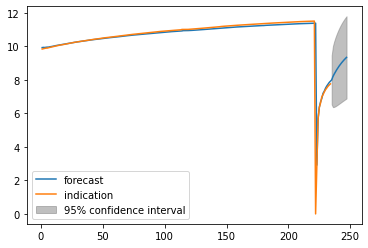

In [ ]:
#Έχουμε 235(δεδομένα 19,5 χρόνια σε μήνες) data points. 
#και θέλουμε να προβλέψουμε του επόμενους 12 data points ή 12 μήνες 
results_ARIMA.plot_predict(1,247) 


In [ ]:
results = results_ARIMA.forecast(steps=12)    
print(np.exp(results[0]))

[ 2985.80870154  3622.47071159  4200.98123171  4799.77868507
  5432.88335064  6100.60673964  6800.25416587  7528.31577832
  8280.96296074  9054.21119218  9844.01403737 10646.33811847]


## **Facebook’s Prophet Model for Time Series Forecasting**

Prophet for forecasting
Το Prophet είναι λογισμικό ανοιχτού κώδικα που κυκλοφόρησε από την ομάδα Core Data Science του Facebook. Το Profet είναι μια διαδικασία για την πρόβλεψη δεδομένων χρονοσειρών βασισμένων σε ένα πρόσθετο μοντέλο όπου οι μη γραμμικές τάσεις ταιριάζουν με την ετήσια, εβδομαδιαία και καθημερινή εποχικότητα, καθώς και εφέ διακοπών. Λειτουργεί καλύτερα με χρονοσειρές που έχουν ισχυρά εποχιακά εφέ και πολλές εποχές ιστορικών δεδομένων . Το Prophet είναι ανθεκτικό στα ελλείποντα δεδομένα και μετατοπίζει την τάση, και συνήθως χειρίζεται καλά τα outliers.


In [ ]:
import pandas as pd 
from fbprophet import Prophet



In [ ]:
df = df.rename(columns = {'timestamp': 'ds', 'indication': 'y'}, inplace = False)


### Check TimeSeries **Stationarity**

In [ ]:
from matplotlib import pyplot
import plotly.graph_objects as go
import statsmodels.api 
# adfuller library 
from statsmodels.tsa.stattools import adfuller
#  kpss library
from statsmodels.tsa.stattools import kpss

def summary_statistics(series):
    X = series.values
    split = round(len(X) / 2)
    X1, X2 = X[0:split], X[split:]
    mean1, mean2 = X1.mean(), X2.mean()
    var1, var2 = X1.var(), X2.var()
    print('Summary Statistics')
    print('mean1=%f, mean2=%f' % (mean1, mean2))
    print('variance1=%f, variance2=%f' % (var1, var2))
    print('')


# check_adfuller
def check_adfuller(series):
    # Dickey-Fuller test
    print ('Results of adfuller Test:')
    result = adfuller(series, autolag='AIC')
    print('Test statistic: ' , result[0])
    print('p-value: '  ,result[1])
    print('Critical Values:' ,result[4])
    print('')
    

#define KPSS
def check_kpss(series):
    print ('Results of KPSS Test:')
    result = kpss(series, regression='c', lags='auto')
    print('Test statistic: ' , result[0])
    print('p-value: '  ,result[1])
    print('Critical Values:' ,result[3])
    print('')


# check_mean_std
def check_mean_std(series):
    #Rolling statistics
    TS = series
    TS['rollmean'] = TS.y.rolling(12).mean()
    TS['rollstd'] = TS.y.rolling(12).std()

    # Create traces
    fig = go.Figure()
    fig.add_trace(go.Scatter(x = TS['ds'], y=TS['y'], name='Original'))
    fig.add_trace(go.Scatter(x = TS['ds'], y=TS['rollmean'], name='Rollling Mean'))
    fig.add_trace(go.Scatter(x = TS['ds'], y=TS['rollstd'], name='Rolling Std'))
    fig.update_layout(title='Check Stationarity with Rolling Mean and Rolling Std ',xaxis_title='Datetime')
    fig.show()
    TS.drop(['rollmean','rollstd'],axis=1,inplace=True)

# Examine the patterns of ACF and PACF (along with the time series plot and histogram)

def tsplot(ts, lags=None, title='', figsize=(14, 8)):
    '''Examine the patterns of ACF and PACF, along with the time series plot and histogram.
    '''
    y = ts.y
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax   = plt.subplot2grid(layout, (0, 0))
    hist_ax = plt.subplot2grid(layout, (0, 1))
    acf_ax  = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))
    
    y.plot(ax=ts_ax)
    ts_ax.set_title(title)
    y.plot(ax=hist_ax, kind='hist', bins=25)
    hist_ax.set_title('Histogram')
    plot_acf(y, lags=lags, ax=acf_ax)
    plot_pacf(y, lags=lags, ax=pacf_ax)
    [ax.set_xlim(0) for ax in [acf_ax, pacf_ax]]
    sns.despine()
    fig.tight_layout()
    
    summary_statistics(y)
    check_adfuller(y)
    check_kpss(y)
    check_mean_std(ts)
    
    return ts_ax, acf_ax, pacf_ax

Summary Statistics
mean1=39488.025424, mean2=72466.213675
variance1=156314890.007828, variance2=759968805.244941

Results of adfuller Test:
Test statistic:  -1.5924981082513352
p-value:  0.487360866562057
Critical Values: {'1%': -3.4586084859607156, '5%': -2.873972159235721, '10%': -2.57339565928848}

Results of KPSS Test:
Test statistic:  1.253925185288672
p-value:  0.01
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}



/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1709: InterpolationWarning:

p-value is smaller than the indicated p-value



(<matplotlib.axes._subplots.AxesSubplot at 0x7fe4dccd1b10>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fe4dcc2b1d0>)

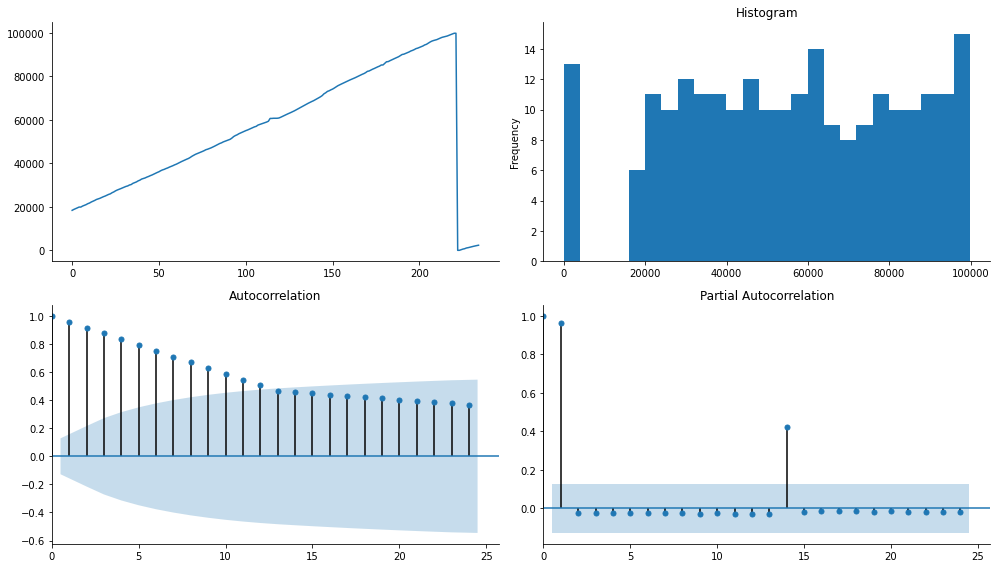

In [ ]:
tsplot(df)

###**Differencing**

Summary Statistics
mean1=361.914530, mean2=-499.111111
variance1=17583.890131, variance2=85106218.731244

Results of adfuller Test:
Test statistic:  -15.156574305061522
p-value:  6.681521117262242e-28
Critical Values: {'1%': -3.458731141928624, '5%': -2.8740258764297293, '10%': -2.5734243167124093}

Results of KPSS Test:
Test statistic:  0.29871509822745984
p-value:  0.1
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}



/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1711: InterpolationWarning:

p-value is greater than the indicated p-value



(<matplotlib.axes._subplots.AxesSubplot at 0x7fe4dc722190>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fe4dc6aabd0>)

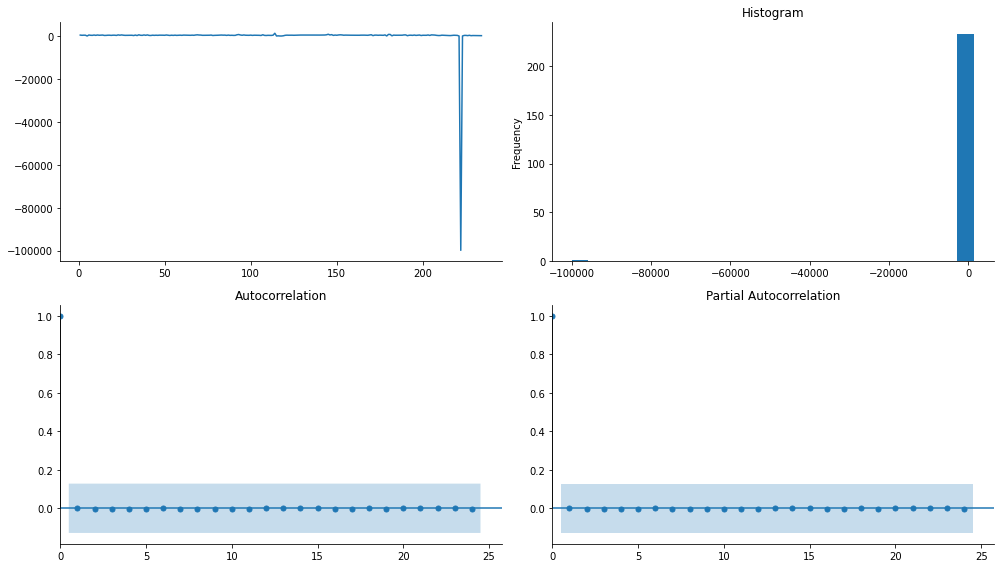

In [ ]:
df.y = df.y.diff()
df.dropna(inplace=True)
# visualization
tsplot(df)

###**Seasonal Differencing**

Summary Statistics
mean1=-8.818966, mean2=3.530435
variance1=37938.234468, variance2=174474273.327335

Results of adfuller Test:
Test statistic:  -0.347578469883056
p-value:  0.9184902624382043
Critical Values: {'1%': -3.460707667106296, '5%': -2.874891213486339, '10%': -2.573885987711472}

Results of KPSS Test:
Test statistic:  0.4999999999999989
p-value:  0.04166666666666692
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}



(<matplotlib.axes._subplots.AxesSubplot at 0x7fe4dc1dc910>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fe4dc107e50>)

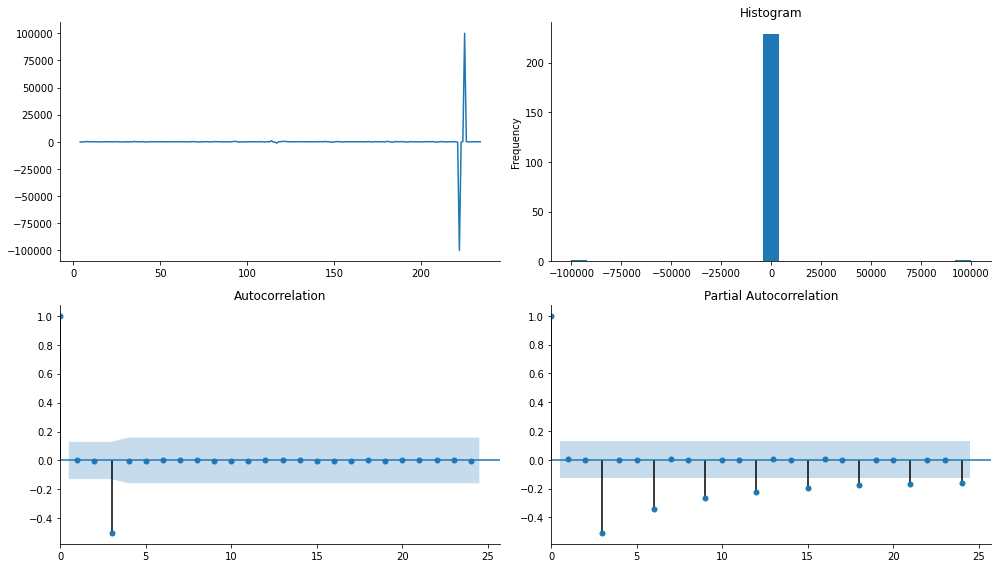

In [ ]:
# Seasonal differencing
df.y =  df.y.diff(3)
df.dropna(inplace=True)
# visualization
tsplot(df)

In [ ]:
model = Prophet()
model.fit(df)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Το επόμενο βήμα είναι να προετοιμάσουμε το μοντέλο μας για να κάνουμε μελλοντικές προβλέψεις. Αυτό επιτυγχάνεται χρησιμοποιώντας τη μέθοδο Prophet.make_future_dataframe και περνώντας τον αριθμό των ημερών για πρόβλεψη στο μέλλον. Χρησιμοποιούμε το χαρακτηριστικό περίοδοι για να το καθορίσουμε.

In [ ]:
future = model.make_future_dataframe(periods=12)
future.tail()

,ds
591,2021-09-11
592,2021-09-12
593,2021-09-13
594,2021-09-14
595,2021-09-15


Στο κομμάτι κώδικα παραπάνω, δώσαμε εντολή στον Prophet να δημιουργήσει 12 σφραγίδες δεδομένων(μήνες) στο μέλλον.
Μετά από αυτό χρησιμοποιήστε τη μέθοδο πρόβλεψης για να κάνετε μελλοντικές προβλέψεις. Αυτό θα δημιουργήσει ένα πλαίσιο δεδομένων με μια στήλη yhat που θα περιέχει τις προβλέψεις. ΤοProfet επιστρέφει ένα μεγάλο DataFrame με πολλές  στήλες, αλλά παρακάτω αναλύονται οι στήλες που σχετίζονται περισσότερο με τις προβλέψεις.

In [ ]:
forecast = model.predict(future)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2001-07-15,-28.758758,-11285.825824,10973.559510,-28.758758,-28.758758,-129.450199,-129.450199,-129.450199,-129.450199,-129.450199,-129.450199,0.0,0.0,0.0,-158.208957
1,2001-08-15,-28.405584,-11837.976246,11209.384812,-28.405584,-28.405584,-52.549496,-52.549496,-52.549496,-52.549496,-52.549496,-52.549496,0.0,0.0,0.0,-80.955080
2,2001-09-15,-28.052410,-16341.781661,5872.811304,-28.052410,-28.052410,-4993.942676,-4993.942676,-4993.942676,-4993.942676,-4993.942676,-4993.942676,0.0,0.0,0.0,-5021.995086
3,2001-10-15,-27.710628,-11690.483950,11331.643894,-27.710628,-27.710628,-154.879472,-154.879472,-154.879472,-154.879472,-154.879472,-154.879472,0.0,0.0,0.0,-182.590100
4,2001-11-15,-27.357454,-11958.863275,11294.933422,-27.357454,-27.357454,32.483087,32.483087,32.483087,32.483087,32.483087,32.483087,0.0,0.0,0.0,5.125633


 yhat είναι η προβλεπόμενη πρόβλεψή μας, 
 yhat_lower είναι το κατώτερο όριο για τις προβλέψεις μας
 και yhat_upper είναι το ανώτερο όριο για τις προβλέψεις μας. 
 ds: η σφραγίδα δεδομένων της προβλεπόμενης τιμής yhat:
  η προβλεπόμενη τιμή της μέτρησης μας (στα στατιστικά στοιχεία, είναι μια σημειογραφία που χρησιμοποιείται παραδοσιακά για να αντιπροσωπεύει τις προβλεπόμενες τιμές μιας τιμής y) 
  yhat_lower: το κάτω όριο των προβλέψεών μας yhat_upper:
   το ανώτερο όριο του τις προβλέψεις μας

In [ ]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2001-07-15,-158.208957,-11285.825824,10973.559510
1,2001-08-15,-80.955080,-11837.976246,11209.384812
2,2001-09-15,-5021.995086,-16341.781661,5872.811304
3,2001-10-15,-182.590100,-11690.483950,11331.643894
4,2001-11-15,5.125633,-11958.863275,11294.933422


Τώρα ας σχεδιάσουμε την πρόβλεψη χρονοσειρών, ο Prophet έχει μια ενσωματωμένη δυνατότητα που μας επιτρέπει να σχεδιάσουμε τις προβλέψεις που μόλις δημιουργήσαμε. Αυτό επιτυγχάνεται χρησιμοποιώντας το mode.plot () και περνάμε στις προβλέψεις μας ως όρισμα.

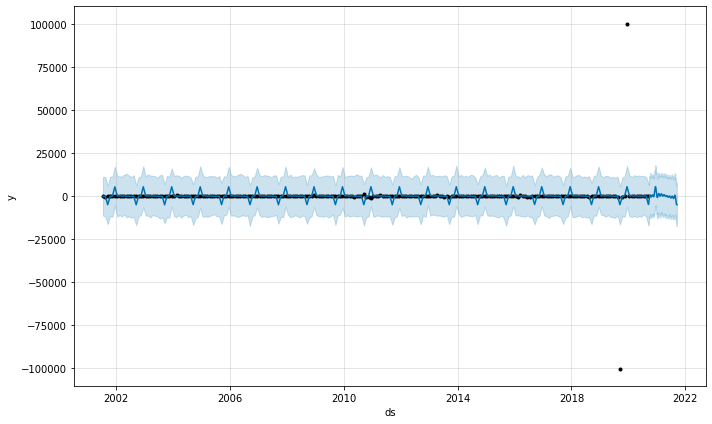

In [ ]:
plot1 = model.plot(forecast)

Παραπάνω  μπορούμε να δούμε το Prophet σχεδιάζει τις παρατηρούμενες τιμές των χρονοσειρών μας (τις μαύρες κουκκίδες), τις προβλεπόμενες τιμές (μπλε γραμμή) και τα διαστήματα αβεβαιότητας των προβλέψεών μας (οι μπλε σκιασμένες περιοχές). Τέλος, το Prophet έχει ισχυρή δυνατότητα να επιστρέψει τα στοιχεία των προβλέψεών μας χρησιμοποιώντας τη μέθοδο plot_components. Σχεδιάζει την τάση, ετήσια και εβδομαδιαία εποχικότητα των δεδομένων χρονοσειρών.

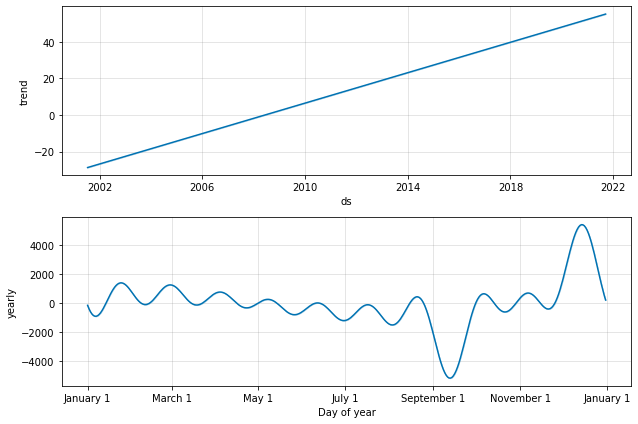

In [ ]:
plot2 = model.plot_components(forecast)